### Part 1: Subreddit Webscraping

In [2]:
from pydantic import BaseModel
from typing import List, Dict

class SubredditComment(BaseModel):
    authorId: str
    author: str
    authorProfile: str
    commentId: str
    link: str
    publishingDate: float
    commentBody: str
    upvotes: int
    total_awards: int
    controversiality: int
    reports: int
    replies: List['SubredditComment'] = []
    
class PublicSubredditPost(BaseModel):
    authorProfile: str
    authorId: str
    title: str
    link: str
    body: str
    subreddit: str
    publishingDate: int
    postId: str
    postLabel: str
    postUpvotes: int
    ratio: float
    matureContent: bool
    postAwards: int
    commentCount: int
    attachmentType: str

class SubredditPost(BaseModel):
    public: PublicSubredditPost
    comments: List[SubredditComment]

class SubredditInfo(BaseModel):
    id: str
    description: str
    members: int
    rank: int
    bookmarks: Dict[str, str]
    url: str

class PublicSubredditData(BaseModel):
    info: SubredditInfo
    posts: List[PublicSubredditPost]
    
class SubredditData(BaseModel):
    info: SubredditInfo
    posts: List[SubredditPost]


In [3]:
from httpx import AsyncClient

client = AsyncClient(
    http2=True,
    headers={
        "Accept-Language": "en-US,en;q=0.9",
        "User-Agent":  "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Cookie": "intl_splash=false"
    },
    follow_redirects=True,
    verify=False
)

In [4]:
import json

from typing import List, Dict, Union, Literal
from httpx import Response
from parsel import Selector
from loguru import logger as log

def parse_subreddit(response: Response, data: Dict) -> Dict[str, list | dict]:
    selector = Selector(response.text)
    url = str(response.url)
    info = {}
    info["id"] = url.split("/r")[-1].replace("/", "").replace('hot', '').replace('new', '').replace('top', '').split("?")[0]
    info["description"] = selector.xpath("//shreddit-subreddit-header/@description").get() or ''
    members = selector.xpath("//shreddit-subreddit-header/@subscribers").get()
    rank = selector.xpath("//strong[@id='position']/*/@number").get()    
    info["members"] = int(members) if members else 0
    info["rank"] = int(rank) if rank else 0
    info["bookmarks"] = {}
    for item in selector.xpath("//div[faceplate-tracker[@source='community_menu']]/faceplate-tracker"):
        name = item.xpath(".//a/span/span/span/text()").get() or ''
        link = item.xpath(".//a/@href").get() or ''
        info["bookmarks"][name] = link

    info["url"] = url
    
    stringify_info = json.dumps(info)
    SubredditInfo.model_validate_json(stringify_info)
    
    post_data = []

    for post in data['data']['children']:
        posting: Dict[str, str | int] = post['data']
        
        payload = {
            "authorProfile": "https://www.reddit.com/user/" + posting.get('author', ''),
            "authorId": posting.get('author_fullname', ''),
            "title": posting.get('title', ''),
            "link": "https://www.reddit.com" + posting.get('permalink', ''),
            "body": posting.get('selftext', ''),
            "subreddit": posting.get('subreddit', ''),
            "publishingDate": posting.get('created_utc', 0),
            "postId": posting.get('name', ''),
            "postLabel": posting.get('link_flair_text', '') or '',
            "postUpvotes": posting.get('ups', 0),
            "ratio": posting.get('upvote_ratio', 0),
            "postAwards": posting.get('total_awards_received', 0),
            "matureContent": posting.get('over_18', False),
            "commentCount": posting.get('num_comments', 0),
            "attachmentType": posting.get('post_hint', ''),
        }
        
        stringify_data = json.dumps(payload)
        PublicSubredditPost.model_validate_json(stringify_data)
        
        post_data.append(payload)
                
    data = {
        "posts" : post_data,
        "info": info
    }
    
    return data


async def scrape_subreddit(subreddit_id: str, sort: Union[Literal["new"], Literal["hot"], Literal["top"]], output_file: str = None) -> PublicSubredditData:
    base_url = f"https://www.old.reddit.com/r/{subreddit_id}/{sort}/"
    suffix= "?t=month" if sort == 'top' else ""
    
    log.info(f"scraping {subreddit_id} with {sort} sort")
    
    json_response = await client.get(f'{base_url}.json{suffix}')
    html_response = await client.get(f'{base_url}{suffix}')
    
    data = json.loads(json_response.text)
    
    parsed_data = parse_subreddit(html_response, data)
    
    if output_file:
        with open(output_file, "w") as json_file:
            json.dump(parsed_data, json_file, indent=4)
    
    stringify_data = json.dumps(parsed_data)
    res = PublicSubredditData.model_validate_json(stringify_data)
    
    log.success(f"finished scraping {subreddit_id} with {res.info.members} members and scraped {len(res.posts)} posts, {sum([post.commentCount for post in res.posts])} comments")
    
    return res

In [5]:
async def parse_post_comments(url: str, sort: Union[Literal["old"], Literal["new"], Literal["top"]]) -> List[Dict]:
    response = await client.get(f'{url.replace("reddit.com", "old.reddit.com")}.json?sort={sort}')
    data = json.loads(response.text)
    surface_comments = []
    
    for entry in data:
        if isinstance(entry['data'], dict) and isinstance(entry['data']['children'], list):
            for child in entry['data']['children']:
                if isinstance(child, dict) and child['kind'] == 't1':
                    surface_comments.append(child['data'])

    def parse_comment(comment: Dict):
        payload = {
            "authorId": comment.get('author_fullname', ''),
            "author": comment.get('author', ''),
            "authorProfile": "https://www.reddit.com/user/" + comment.get('author', ''),
            "commentId": comment.get('name', ''),
            "link": "https://www.reddit.com" + comment.get('permalink', ''),
            "publishingDate": comment.get('created_utc', 0),
            "commentBody": comment.get('body', ''),
            "upvotes": int(comment.get('ups', 0)),
            "total_awards": int(comment.get('total_awards_received', 0)),
            "controversiality": int(comment.get('controversiality', 0)),
            "reports": len(comment.get('user_reports', [])) if isinstance(comment.get('user_reports', []), list) else 0,
        }
        
        stringify_data = json.dumps(payload)
        SubredditComment.model_validate_json(stringify_data)
        
        return payload
    
    def parse_replies(comment: Dict) -> List[Dict]:
        replies = []
        found_replies_object = comment.get('replies', None)
        
        if found_replies_object and isinstance(found_replies_object, dict) and isinstance(found_replies_object['data']['children'], list):
            for reply in comment['replies']['data']['children']:
                reply_comment = parse_comment(reply['data'])
                child_replies = parse_replies(reply['data'])

                if child_replies:
                    reply_comment["replies"] = child_replies
                    
                stringify_data = json.dumps(reply_comment)
                SubredditComment.model_validate_json(stringify_data)
                
                replies.append(reply_comment)
                
        return replies
    
    comments = []
    
    for comment in surface_comments:
        comment_obj = parse_comment(comment)
        comment_obj['replies'] = parse_replies(comment)
        comments.append(comment_obj)
    
    return comments

async def get_comments_from_url(url: str, sort: Union[Literal["old"], Literal["new"], Literal["top"]], output_file: str = None) -> List[SubredditComment]:
    post_data = await parse_post_comments(url=url, sort=sort) 

    for comment in post_data:
        stringify_data = json.dumps(comment)
        SubredditComment.model_validate_json(stringify_data)
    
    if output_file:
        with open(output_file, 'w') as f:
            json.dump(post_data, f, indent=4)
    
    stringify_data = json.dumps(post_data)
    res = [SubredditComment.model_validate_json(json.dumps(comment)) for comment in post_data]
    
    return res
    
async def scrape_post(public: PublicSubredditPost, sort: Union[Literal["old"], Literal["new"], Literal["top"]], output_file: str = None) -> SubredditPost:
    post_data = {}
    
    post_data["public"] = public.model_dump()
    post_data["comments"] = await parse_post_comments(url=public.link, sort=sort)

    stringify_data = json.dumps(post_data)
    res = SubredditPost.model_validate_json(stringify_data)
    
    if output_file:
        with open(output_file, 'w') as f:
            json.dump(post_data, f, indent=4)
    
    return res


In [6]:

async def scrape_and_populate_subreddit(subreddit_id: str, sort: Union[Literal["new"], Literal["hot"], Literal["old"]], output_file: str = None, public_output_file: str = None) -> SubredditData:
    subreddit_data = await scrape_subreddit(subreddit_id, sort, public_output_file)
    subreddit_data.posts = subreddit_data.posts[:50]
    populated_posts = []
    
    for i, post in enumerate(subreddit_data.posts):
        log.info(f'scraping post {i + 1}/{len(subreddit_data.posts)}: {post.title} at {post.link}')
        try:
            populated_post = await scrape_post(post, 'top')
            log.success(f'Finished scraping post {i + 1}/{len(subreddit_data.posts)} with {populated_post.public.postUpvotes} upvotes and {len(populated_post.comments)} comments')
            
            stringify_data = json.dumps(populated_post.model_dump())
            SubredditPost.model_validate_json(stringify_data)
            
            populated_posts.append(populated_post.model_dump())
        except Exception as e:
            log.error(f'error scraping post {i + 1}/{len(subreddit_data.posts)}: {e}')

    new_data = {
        'info': subreddit_data.info.model_dump(),
        'posts': populated_posts
    }
    
    if output_file:
        with open(output_file, "w") as json_file:
            json.dump(new_data, json_file, indent=4)
        
    stringify_data = json.dumps(new_data)
    res = SubredditData.model_validate_json(stringify_data)
    
    return res

In [7]:
# currentDate = strftime("%Y-%m-%d")
currentDate = "2025-04-04"

class SubredditQueryClient():
    def __init__(self, target: str, sort: str = "top"):
        self.id: str = target
        self.target: str = target
        self.sort: str = sort
        self.data_path: str = f"./data/{self.target}_data_{currentDate}.json"
        self.public_data_path: str = f"./data/{self.target}_public_data_{currentDate}.json"
        
    async def scrape_sub(self) -> PublicSubredditData:
        res = await scrape_subreddit(self.target, self.sort)
        return res
    
    async def scrape_post(self, public: PublicSubredditPost) -> SubredditPost:
        res = await scrape_post(public, self.sort)
        return res
    
    async def scrape_and_populate(self) -> SubredditData:
        res = await scrape_and_populate_subreddit(self.target, self.sort, self.data_path, self.public_data_path)
        return res
        
    def load_data(self) -> tuple[SubredditData, PublicSubredditData]:
        data: SubredditData | None = None
        public_data: PublicSubredditData | None = None
        
        with open(self.data_path, "r") as f:
            data = SubredditData.model_validate_json(json.dumps(json.load(f)))
            
        with open(self.public_data_path, "r") as f:
            public_data = PublicSubredditData.model_validate_json(json.dumps(json.load(f)))
            
        return data, public_data

queries = [
    SubredditQueryClient(target="uwaterloo"),
    SubredditQueryClient(target="slaythespire"),
    SubredditQueryClient(target="wallstreetbets"),
    SubredditQueryClient(target="Kanye"),
    SubredditQueryClient(target="balatro"),
    SubredditQueryClient(target="dankmemes"),
    SubredditQueryClient(target="Conservative"),
    SubredditQueryClient(target="PedroPeepos")
]

data = []

In [8]:
#we have to do this in batches unfortunately

selected_indices = []

for selected_index in selected_indices:
    res = await queries[selected_index].scrape_and_populate()

    data.append({
        "id": queries[selected_indices[0]].id,
        "data": res.model_dump()
    })

### Part 2: Data Processing

In [9]:
# let's put all the data into dataframes

import pandas as pd

df = pd.DataFrame()

for query in queries:
    (_, public_dataset) = query.load_data()

    posts_data = []
    for post in public_dataset.posts:
        post_data = {key: value for key, value in post}
        post_data['subredditMembers'] = public_dataset.info.members
        posts_data.append(post_data)

    df = pd.concat([df, pd.DataFrame(posts_data)])
    
df.to_csv('subreddit_public_data.csv', index=False)



2025-04-04 01:28:07.860 | INFO     | __main__:<module>:24 - R-score for Subreddit Members vs Comment Count: 0.6783439705189463


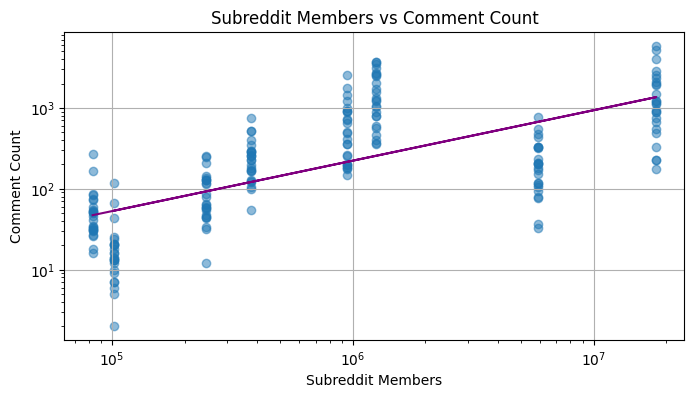

2025-04-04 01:28:08.036 | INFO     | __main__:<module>:43 - R-score for Subreddit Members vs Post Upvotes: 0.7798813766627555


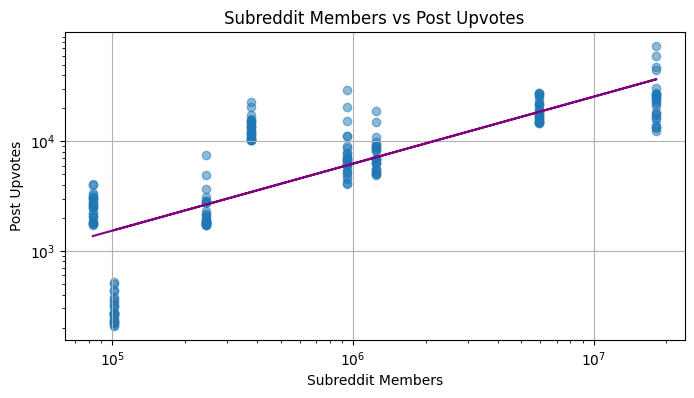

2025-04-04 01:28:08.216 | INFO     | __main__:<module>:62 - R-score for Post Upvotes vs Comment Count: 0.7391183137103435


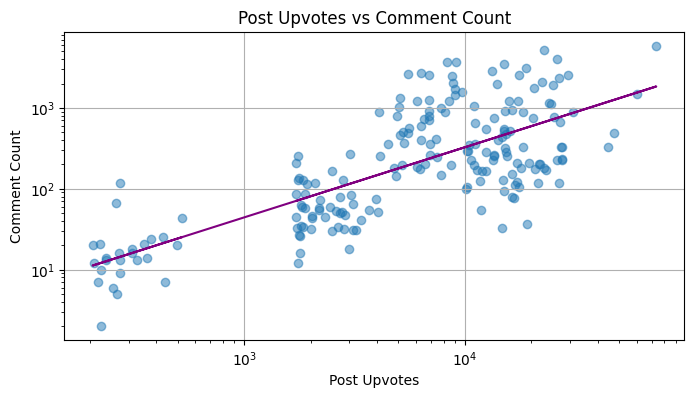

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

df['subredditMembers'] = pd.to_numeric(df['subredditMembers'])
df['commentCount'] = pd.to_numeric(df['commentCount'])
df['postUpvotes'] = pd.to_numeric(df['postUpvotes'])

# Plot Subreddit Members vs Comment Count
plt.figure(figsize=(8, 4))
plt.scatter(df['subredditMembers'], df['commentCount'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Subreddit Members vs Comment Count')
plt.xlabel('Subreddit Members')
plt.ylabel('Comment Count')
plt.grid(True)

z = np.polyfit(np.log(df['subredditMembers']), np.log(df['commentCount']), 1)
p = np.poly1d(z)
plt.plot(df['subredditMembers'], np.exp(p(np.log(df['subredditMembers']))), "-", color="purple")

slope, intercept, r_value, p_value, std_err = linregress(np.log(df['subredditMembers']), np.log(df['commentCount']))
log.info(f"R-score for Subreddit Members vs Comment Count: {r_value}")

plt.show()

# Plot Subreddit Members vs Post Upvotes
plt.figure(figsize=(8, 4))
plt.scatter(df['subredditMembers'], df['postUpvotes'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Subreddit Members vs Post Upvotes')
plt.xlabel('Subreddit Members')
plt.ylabel('Post Upvotes')
plt.grid(True)

z = np.polyfit(np.log(df['subredditMembers']), np.log(df['postUpvotes']), 1)
p = np.poly1d(z)
plt.plot(df['subredditMembers'], np.exp(p(np.log(df['subredditMembers']))), "-", color="purple")

slope, intercept, r_value, p_value, std_err = linregress(np.log(df['subredditMembers']), np.log(df['postUpvotes']))
log.info(f"R-score for Subreddit Members vs Post Upvotes: {r_value}")

plt.show()

# Plot Post Upvotes vs Comment Count
plt.figure(figsize=(8, 4))
plt.scatter(df['postUpvotes'], df['commentCount'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Post Upvotes vs Comment Count')
plt.xlabel('Post Upvotes')
plt.ylabel('Comment Count')
plt.grid(True)

z = np.polyfit(np.log(df['postUpvotes']), np.log(df['commentCount']), 1)
p = np.poly1d(z)
plt.plot(df['postUpvotes'], np.exp(p(np.log(df['postUpvotes']))), "-", color="purple")

slope, intercept, r_value, p_value, std_err = linregress(np.log(df['postUpvotes']), np.log(df['commentCount']))
log.info(f"R-score for Post Upvotes vs Comment Count: {r_value}")

plt.show()


In [31]:
populated_df = pd.DataFrame()

for query in queries:
    log.info(f"Processing {query.target}")
    
    (data, public_data) = query.load_data()
    
    comments = []
    
    for post in data.posts:
        post_data = {f'post_{key}': value for key, value in post.public.model_dump().items() if key in ['postId', 'title', 'link', 'postUpvotes', 'subreddit']}
        post_data['subredditMembers'] = public_data.info.members
        
        queue, next = post.comments, []
        depth = 0
        
        while queue:
            depth += 1
            queue.extend(post.comments)
            
            for i, comment in enumerate(queue):
                comment_data = {**post_data, **{f'comment_{key}': value for key, value in comment.model_dump().items() if key != 'replies'}}
                comment_data['depth'] = depth
                
                if comment.commentBody != '':
                    comments.append(comment_data)
                
                if comment.replies and isinstance(comment.replies, list):
                    next.extend(comment.replies)
                
            queue = next
            next = []
            
            if depth > 5:
                break
        
    comments_df = pd.DataFrame(comments)
    populated_df = pd.concat([populated_df, comments_df])
    
    log.success(f"Finished processing {query.target}, added {len(comments_df)} rows")

populated_df.to_csv('large_populated_subreddit_data.csv', index=False)
populated_df.fillna('', inplace=True)

print(populated_df.shape)

populated_df.head()

2025-04-04 14:17:36.235 | INFO     | __main__:<module>:4 - Processing uwaterloo
2025-04-04 14:17:36.449 | SUCCESS  | __main__:<module>:40 - Finished processing uwaterloo, added 5366 rows
2025-04-04 14:17:36.449 | INFO     | __main__:<module>:4 - Processing slaythespire
2025-04-04 14:17:36.925 | SUCCESS  | __main__:<module>:40 - Finished processing slaythespire, added 21466 rows
2025-04-04 14:17:36.925 | INFO     | __main__:<module>:4 - Processing wallstreetbets
2025-04-04 14:17:37.381 | SUCCESS  | __main__:<module>:40 - Finished processing wallstreetbets, added 41048 rows
2025-04-04 14:17:37.381 | INFO     | __main__:<module>:4 - Processing Kanye
2025-04-04 14:17:37.737 | SUCCESS  | __main__:<module>:40 - Finished processing Kanye, added 41700 rows
2025-04-04 14:17:37.738 | INFO     | __main__:<module>:4 - Processing balatro
2025-04-04 14:17:38.087 | SUCCESS  | __main__:<module>:40 - Finished processing balatro, added 39718 rows
2025-04-04 14:17:38.087 | INFO     | __main__:<module>:4 

(214628, 18)


,post_title,post_link,post_subreddit,post_postId,post_postUpvotes,subredditMembers,comment_authorId,comment_author,comment_authorProfile,comment_commentId,comment_link,comment_publishingDate,comment_commentBody,comment_upvotes,comment_total_awards,comment_controversiality,comment_reports,depth
0,Uwaterloo filed action against my stupid littl...,https://www.reddit.com/r/uwaterloo/comments/1j...,uwaterloo,t3_1j8wytt,521,101736,t2_1p3i8yvz,picklewalrusman,https://www.reddit.com/user/picklewalrusman,t1_mh8px7f,https://www.reddit.com/r/uwaterloo/comments/1j...,1.741716e+09,If it doesn't say university of Waterloo on it...,280,0,0,0,1
1,Uwaterloo filed action against my stupid littl...,https://www.reddit.com/r/uwaterloo/comments/1j...,uwaterloo,t3_1j8wytt,521,101736,t2_qrji3lj,treema94,https://www.reddit.com/user/treema94,t1_mh8s4e8,https://www.reddit.com/r/uwaterloo/comments/1j...,1.741717e+09,I didn’t know you could copyright a goose,205,0,0,0,1
2,Uwaterloo filed action against my stupid littl...,https://www.reddit.com/r/uwaterloo/comments/1j...,uwaterloo,t3_1j8wytt,521,101736,t2_58g42twf,Hot-Sandwich7060,https://www.reddit.com/user/Hot-Sandwich7060,t1_mh8xikh,https://www.reddit.com/r/uwaterloo/comments/1j...,1.741718e+09,Looks to me like the art work just celebrates ...,109,0,0,0,1
3,Uwaterloo filed action against my stupid littl...,https://www.reddit.com/r/uwaterloo/comments/1j...,uwaterloo,t3_1j8wytt,521,101736,t2_14vfoggoiy,Reasonable-MessRedux,https://www.reddit.com/user/Reasonable-MessRedux,t1_mh8ryx5,https://www.reddit.com/r/uwaterloo/comments/1j...,1.741717e+09,Ask some other law school to help. This is bul...,109,0,0,0,1
4,Uwaterloo filed action against my stupid littl...,https://www.reddit.com/r/uwaterloo/comments/1j...,uwaterloo,t3_1j8wytt,521,101736,t2_17tcsqqk,the-paper-unicorn,https://www.reddit.com/user/the-paper-unicorn,t1_mh90bqg,https://www.reddit.com/r/uwaterloo/comments/1j...,1.741719e+09,A lawyer in the area will likely afford you a ...,92,0,0,0,1


In [30]:
unique_post_ids = populated_df['post_postId'].nunique()
print(f"Number of unique post_postId: {unique_post_ids}")

unique_comment_ids = populated_df['comment_commentId'].nunique()
print(f"Number of unique comment_commentId: {unique_comment_ids}")

print(f"Total comments: {np.sum(df['commentCount'])}")

Number of unique post_postId: 200
Number of unique comment_commentId: 10031
Total comments: 115316
